In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np

df = pd.read_parquet('data/rucphen_precipitation_clean_updated.parquet')

In [2]:
def create_plot(df, x,xlabel, y, ylabel, title):
    # Create a line plot using seaborn
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x = x, y = y)

    # Set labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Display the plot
    plt.show()
def show_df(df, start = pd.to_datetime('2020-02-01 08:00:00'), end = pd.to_datetime('2023-11-01 08:00:00')):
    # Define the start and end timestamps
    start_timestamp = start
    end_timestamp = end

    # Create a boolean mask for the specified time range
    mask = (df['timestamp'] >= start_timestamp) & (df['timestamp'] < end_timestamp)

    # Apply the mask to get the desired slice of the DataFrame
    result_df = df[mask]

    create_plot(result_df, 'timestamp','Timestamp', 'precipitation','mm', 'Line Plot: Rainfall over time')
    create_plot(result_df, 'timestamp','Timestamp', 'percentage','%', 'Line Plot: Percentage full over time')


In [3]:
# show_df(df, pd.to_datetime('2020-06-01 08:00:00'), pd.to_datetime('2023-10-01 08:00:00'))

In [4]:
start_timestamp = pd.to_datetime('2021-01-01 08:00:00')
end_timestamp = pd.to_datetime('2022-12-01 08:00:00')

# Create a boolean mask for the specified time range
mask = (df['timestamp'] >= start_timestamp) & (df['timestamp'] < end_timestamp)

# Apply the mask to get the desired slice of the DataFrame
df_reduced = df[mask]
df_reduced.fillna(0, inplace=True)
# show_df(df_reduced)

/tmp/ipykernel_245489/983979855.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced.fillna(0, inplace=True)


In [5]:
def df_features_of_df(df: pd.DataFrame):
    # Datetime features
    # Extracting features
    df_features = df.copy()
    # df_features['percentage_delta'] = df_features['percentage'].diff()
    # df_features['percentage_delta'].fillna(0, inplace=True)
    print(df_features)

    df_features['hour'] = df_features['timestamp'].dt.hour
    df_features['dayofweek'] = df_features['timestamp'].dt.hour
    df_features['month'] = df_features['timestamp'].dt.hour

    # Define the lags you want
    # precipitation_lags = [1, 2, 3, 4, 5, 6]
    # percentage_delta_lags = [1, 2, 3, 4]
    percentage_lags = [1, 2, 3, 4, 5, 6]

    # df_features['precipitation_0-30'] = df_features['precipitation'].rolling(6, min_periods=1).sum()
    df_features['precipitation_0-60'] = df_features['precipitation'].rolling(12, min_periods=1).sum()
    df_features['precipitation_60-120'] = df_features['precipitation'].shift(13).rolling(12, min_periods=1).sum()
    # df_features['precipitation_90-120'] = df_features['precipitation'].rolling(24, min_periods=1).sum()
    
    # df_features['percentage_0-30'] = df_features['precipitation'].rolling(6, min_periods=1).sum()
    df_features['percentage_30-60'] = df_features['percentage'].shift(7).rolling(6, min_periods=1).sum()
    df_features['percentage_60-90'] = df_features['percentage'].shift(13).rolling(6, min_periods=1).sum()
    # df_features['percentage_90-120'] = df_features['precipitation'].rolling(24, min_periods=1).sum()

    # df_features['precipitation_0-180'] = df_features['precipitation'].rolling(30, min_periods=1).sum()
    # df_features['precipitation_0-240'] = df_features['precipitation'].rolling(36, min_periods=1).sum()
    # df_features['percentage_0-30'] = df_features['percentage'].rolling(6, min_periods=1).sum()
    # df_features['percentage_delta_30-60'] = df_features['percentage_delta'].shift(5).rolling(8, min_periods=1).sum()
    # df_features['percentage_delta_60-90'] = df_features['percentage_delta'].shift(13).rolling(6, min_periods=1).sum()
    # df_features['percentage_delta_90-120'] = df_features['percentage_delta'].shift(19).rolling(6, min_periods=1).sum()

    # Add lag features for 'precipitation'
    # for lag in precipitation_lags:
    #     df_features[f'precipitation_lag_{lag}'] = df_features['precipitation'].shift(lag)

    # Add lag features for 'percentage_delta'
    # for lag in percentage_delta_lags:
    #     df_features[f'percentage_delta_lag_{lag}'] = df_features['percentage_delta'].shift(lag)

    # Add lag features for 'percentage'
    for lag in percentage_lags:
        df_features[f'percentage_lag_{lag}'] = df_features['percentage'].shift(lag)

    return df_features

In [6]:
df_features = df_features_of_df(df_reduced)
# Drop rows with NaN values introduced by the lag operation
df_features.dropna(inplace=True)

# Reset index to integers
df_features = df_features.reset_index(drop=True)
# df_features.head()

                 timestamp  precipitation  percentage
208297 2021-01-01 08:00:00            0.0       0.000
208298 2021-01-01 08:05:00            0.0       0.000
208299 2021-01-01 08:10:00            0.0       0.000
208300 2021-01-01 08:15:00            0.0       0.000
208301 2021-01-01 08:20:00            0.0       0.000
...                    ...            ...         ...
409004 2022-12-01 07:35:00            0.0       1.754
409005 2022-12-01 07:40:00            0.0       1.754
409006 2022-12-01 07:45:00            0.0       1.754
409007 2022-12-01 07:50:00            0.0       1.754
409008 2022-12-01 07:55:00            0.0       1.754

[200712 rows x 3 columns]


In [7]:
# Extract features and target from the DataFrame

X = df_features.copy()
# X.drop(columns=['timestamp', 'percentage', 'percentage_delta'], inplace=True)
# y = df_features['percentage_delta']

X.drop(columns=['timestamp', 'percentage'], inplace=True)
y = df_features['percentage']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y.to_numpy().reshape(-1, 1), test_size=0.5, shuffle=False)


# Standardize Data
# class MinMaxPositiveScaler:
#     def __init__(self):
#         self.min_max_scaler = MinMaxScaler()

#     def fit(self, X):
#         self.min_max_scaler.fit(X)
#         return self

#     def transform(self, X):
#         scaled_data = self.min_max_scaler.transform(X)
#         shifted_data = scaled_data + abs(np.min(scaled_data)) # Shift to make all numbers positive
#         return shifted_data
    
#     def inverse_transform(self, X):
#         scaled_data = self.min_max_scaler.inverse_transform(X)
#         shifted_data = scaled_data - abs(np.min(scaled_data))  # Shift numbers back
#         return shifted_data

#     def fit_transform(self, X):
#         self.fit(X)
#         return self.transform(X)

scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

def scale_X(df: pd.DataFrame):
    return scaler_X.transform(df)
def scale_y(df: pd.DataFrame):
    return scaler_y.transform(df)

In [8]:
# print("Number of samples in X_train_scaled:", len(X_train_scaled))
# print("Number of samples in y_train:", len(y_train_scaled))
# print("Number of samples in X_test_scaled:", len(X_test_scaled))
# print("Number of samples in y_test:", len(y_test_scaled))

y_train_scaled

array([[0.02632],
       [0.02632],
       [0.02632],
       ...,
       [0.     ],
       [0.     ],
       [0.     ]])

In [9]:
import optuna
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import xgboost as xgb
from joblib import dump, load
from pandas.api.types import CategoricalDtype  # Add this import
import optuna
import warnings


# Suppress FutureWarnings related to is_categorical_dtype
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost.data")

def objective(trial):
    # Assuming X_train_scaled, y_train_scaled are already defined
    model = xgb.XGBRegressor(
        tree_method='gpu_hist',
        verbosity=0,
        gpu_id=1,
        n_jobs=15,
        # gbtree and dart - use tree-based models, while
        # gblinear uses linear models. 'We will limit our discussion to tree booster because it always outperforms the linear booster and thus the later is rarely used.'
        booster=trial.suggest_categorical('booster', ['dart', 'gbtree']),
        # Typical final values : 0.01-0.2.
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.5),
        n_estimators=trial.suggest_categorical('n_estimators', [50, 100, 200]),
        # Typical values: 3-10. Trying higher values as the Random Forest model works best at 14
        max_depth=trial.suggest_int('max_depth',0,20),
        # Range: [0,∞]. 'Practically, the limit for gamma is around 20 and extremely rare (Laurae, 2016).'
        gamma=trial.suggest_float('gamma', 0, 20),
        subsample=trial.suggest_float('subsample', 0.8, 1.0),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.3, 1),
        # range: [0,∞]
        min_child_weight=trial.suggest_float('min_child_weight', 0, 20)
    )

    # TimeSeriesSplit with 5 splits
    # tscv = TimeSeriesSplit(n_splits=10)
    
    # # Define scoring using MSE only
    # scoring = make_scorer(mean_squared_error, greater_is_better=False)

    # Cross-validation
    # scores = cross_val_score(
    #     model, X_train_scaled, y_train_scaled.ravel(), cv=tscv, scoring='neg_mean_squared_error', n_jobs=20, verbose=1
    # )
    # scores_r2 = cross_val_score(
    #     model, X_train_scaled, y_train_scaled.ravel(), cv=tscv, scoring='r2', n_jobs=40, verbose=1
    # )
    model.fit(X_train, y_train)
    predictions = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test_scaled.ravel(), predictions)
    r2 = r2_score(y_test_scaled.ravel(), predictions)

    # Optimize for the average MSE

    return mse, r2

train = True

if train:
    study = optuna.create_study(directions=['minimize','maximize'])
    study.optimize(objective, n_trials=100)

    # Get the best hyperparameters
    # Select the first
    best_params = study.best_trials[0].params
    
    # Print the best parameters
    for best_trial in study.best_trials:
        print(f"Best values: {best_trial.values} | best params: {best_trial.params}")
    
    # Train XGBoost Model with the best hyperparameters
    best_model = xgb.XGBRegressor(
        tree_method='gpu_hist',
        verbosity=1,
        gpu_id=1,
        **best_params
    )

    best_model.fit(X_test_scaled, y_test_scaled.ravel())

    # Save the model
    dump(best_model, './models/xgboost_optuna.joblib')

else:
    # Load the pre-trained model
    best_model = load('./models/xgboost_optuna.joblib')

[I 2023-12-19 23:26:57,946] A new study created in memory with name: no-name-81045ab7-8651-4859-871c-6f57e1991d33
[I 2023-12-19 23:26:58,759] Trial 0 finished with values: [0.0076665979193735545, 0.8224437565510919] and parameters: {'booster': 'dart', 'learning_rate': 0.07929845036644569, 'n_estimators': 50, 'max_depth': 20, 'gamma': 2.7211028232997703, 'subsample': 0.9229621208576652, 'colsample_bytree': 0.9991105357428154, 'min_child_weight': 14.030759707746407}. 
[I 2023-12-19 23:26:58,987] Trial 1 finished with values: [0.005701012932975185, 0.8679661499301078] and parameters: {'booster': 'gbtree', 'learning_rate': 0.20450198538924658, 'n_estimators': 200, 'max_depth': 14, 'gamma': 16.519102235759295, 'subsample': 0.9080314956695685, 'colsample_bytree': 0.7892393032406686, 'min_child_weight': 10.859089202369125}. 
[I 2023-12-19 23:26:59,178] Trial 2 finished with values: [0.005558324732808448, 0.8712707683635421] and parameters: {'booster': 'gbtree', 'learning_rate': 0.088976608403

Best values: [0.0013599644726238753, 0.9685036067467587] | best params: {'booster': 'dart', 'learning_rate': 0.0929151553866228, 'n_estimators': 200, 'max_depth': 1, 'gamma': 17.83744546597874, 'subsample': 0.9010336505153784, 'colsample_bytree': 0.7915874246700657, 'min_child_weight': 0.6509974364506688}


In [10]:
import pickle
# Train best model

# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_




Mean Squared Error: 0.049590624062741485
r2: -0.14850485332180874


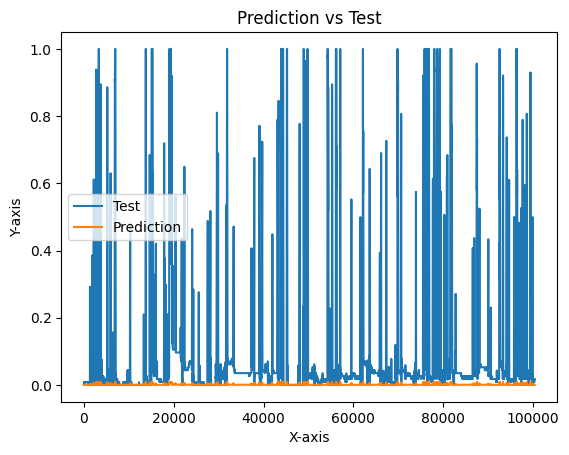

In [11]:
def predict(X_test_scaled, model):
    # Make Predictions
    return scale_y(best_model.predict(X_test_scaled).reshape(-1, 1))

def evaluate(y_test, predictions):

    # # Use np.clip to limit values between 0 and 100
    # predictions_clipped = np.clip(predictions, 0, 100)

    # Evaluate the Model
    mse = mean_squared_error(y_test, predictions)
    print(f'Mean Squared Error: {mse.item()}')

    r2 = r2_score(y_test, predictions)
    print(f'r2: {r2.item()}')

    # Plotting
    plt.plot(y_test, label='Test')
    plt.plot(predictions, label='Prediction')

    # Adding labels and title
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Prediction vs Test')

    # Adding legend
    plt.legend()

    # Display the plot
    plt.show()

def predict_and_evaluate(X_test_scaled, y_test, model):
    predictions = predict(X_test_scaled, model)
    evaluate(y_test, predictions)

predict_and_evaluate(X_test_scaled, y_test_scaled, best_model)

                 Feature  Importance
0       percentage_lag_1    0.887514
1       percentage_lag_2    0.112486
2       percentage_lag_6    0.000000
3       percentage_lag_5    0.000000
4       percentage_lag_4    0.000000
5       percentage_lag_3    0.000000
6       percentage_60-90    0.000000
7       percentage_30-60    0.000000
8   precipitation_60-120    0.000000
9     precipitation_0-60    0.000000
10                 month    0.000000
11             dayofweek    0.000000
12                  hour    0.000000
13         precipitation    0.000000


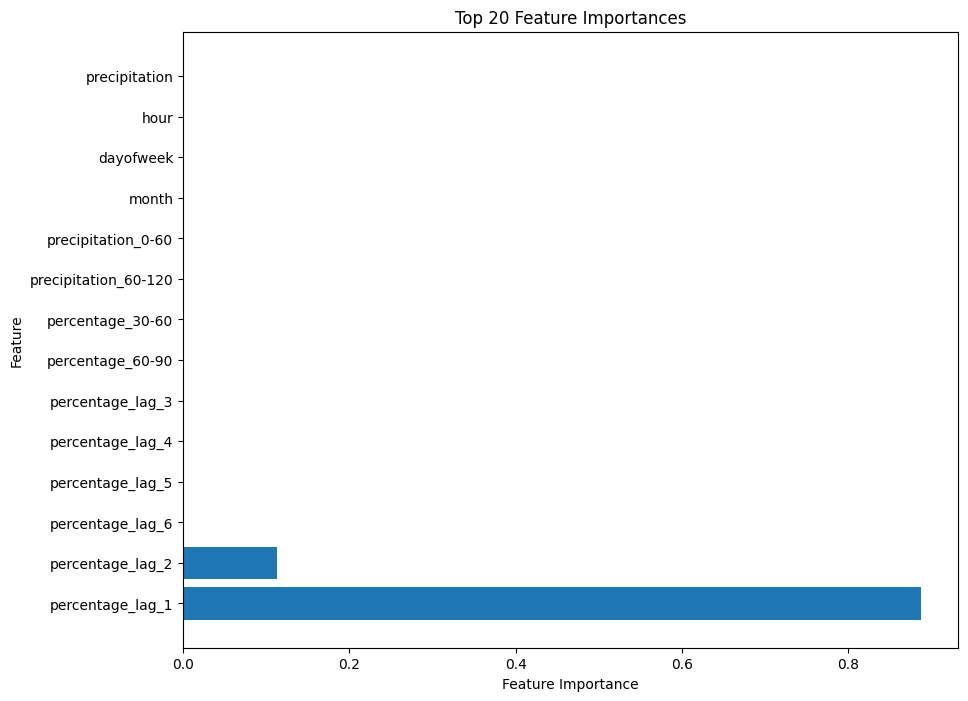

In [12]:
from matplotlib import pyplot as plt

def plot_importances(model, feature_names):
    # Get feature importances from the model
    importances = model.feature_importances_

    # Sort indices and feature names
    indices = np.argsort(importances)[::-1]
    feature_names = [feature_names[i] for i in indices]

    # Create a DataFrame for better visualization
    df_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances[indices]})

    # Display the top 20 features
    print(df_importances.head(20))

    # Create a horizontal bar plot
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(feature_names)), importances[indices], align='center')

    # Set y-axis labels
    plt.yticks(range(len(feature_names)), feature_names)

    # Display the plot
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Top 20 Feature Importances')
    plt.show()

# Assuming best_model is your trained XGBoost model and X is your feature matrix
plot_importances(best_model, X.columns.tolist())


In [ ]:
from datetime import timedelta
def predict_one_step(X_test:pd.DataFrame, X_weather:pd.DataFrame):
    # X_test_filtered = X_test.drop(columns=['percentage_delta', 'percentage', 'timestamp'])
    X_test_filtered = X_test.drop(columns=['percentage', 'timestamp'])
    X_test_scaled = scale_X(X_test_filtered.tail(1))
    input = X_test.tail(1)

    percentage_delta = scale_y(predict(X_test_scaled, best_model)[0].reshape(-1, 1))

    # print('here', percentage_delta_clipped)

    future_timestamp = input['timestamp'].values[0] + + np.timedelta64(5, 'm')
    precipitation_row = X_weather[future_timestamp == X_weather['timestamp']].iloc[0]

    new_row = {
        'timestamp':future_timestamp,
        'precipitation': precipitation_row['precipitation'],
        # 'percentage_delta': percentage_delta,
        # 'percentage': input['percentage'].values[0] + percentage_delta
        'percentage': input['percentage'].values[0]
        }
    # df_unprocessed = pd.concat([X_test[['timestamp', 'percentage', 'percentage_delta', 'precipitation' ]], pd.DataFrame([new_row])], ignore_index=True)
    df_unprocessed = pd.concat([X_test[['timestamp', 'percentage', 'precipitation' ]], pd.DataFrame([new_row])], ignore_index=True)
    return df_features_of_df(df_unprocessed)
    
X_original = df_features_of_df(df_reduced)
first_nan_index = X_original['precipitation_60-120'].notna().idxmax()
X_result = X_original.copy()
X_result = X_result[X_result.index <= first_nan_index]
for i in range(0,int(len(X_original)/50)):
    X_result = predict_one_step(X_result,X_original)


# X_result[['percentage_delta', 'precipitation']].plot()
X_result[['percentage', 'precipitation']].plot()
X_result

                 timestamp  precipitation  percentage
208297 2021-01-01 08:00:00            0.0       0.000
208298 2021-01-01 08:05:00            0.0       0.000
208299 2021-01-01 08:10:00            0.0       0.000
208300 2021-01-01 08:15:00            0.0       0.000
208301 2021-01-01 08:20:00            0.0       0.000
...                    ...            ...         ...
409004 2022-12-01 07:35:00            0.0       1.754
409005 2022-12-01 07:40:00            0.0       1.754
409006 2022-12-01 07:45:00            0.0       1.754
409007 2022-12-01 07:50:00            0.0       1.754
409008 2022-12-01 07:55:00            0.0       1.754

[200712 rows x 3 columns]
             timestamp  percentage  precipitation
0  2021-01-01 08:00:00       0.000            0.0
1  2021-01-01 08:05:00       0.000            0.0
2  2021-01-01 08:10:00       0.000            0.0
3  2021-01-01 08:15:00       0.000            0.0
4  2021-01-01 08:20:00       0.000            0.0
5  2021-01-01 08:25:00   